In [1]:
import pandas as pd
import numpy as np
import sklearn
from math import pi
from tqdm.auto import tqdm
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
import time


In [2]:
import pickle
import os
import joblib
import json
from datetime import datetime

In [3]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 85.9 MB/s eta 0:00:00


In [48]:
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from typing import List, Tuple, Dict, Any
from sklearn.multioutput import RegressorChain

In [5]:
import datetime
import IPython
from google.colab import output
from IPython.display import display, HTML
import threading

In [6]:
# Read from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import warnings
warnings.filterwarnings('ignore')

In [85]:
warnings.filterwarnings('ignore', message='No further splits with positive gain')

In [8]:
def keep_alive():
    # Define JavaScript code
    js_code = """
    function KeepClicking() {
        console.log("Keeping session alive");
        if (document.querySelector("colab-connect-button")) {
            document.querySelector("colab-connect-button").click();
        }

        // Simulate mouse movement
        document.dispatchEvent(new MouseEvent('mousemove', {
            'view': window,
            'bubbles': true,
            'cancelable': true
        }));
    }

    // Run every 10 minutes
    setInterval(KeepClicking, 600000);
    console.log("Keep-alive activated");
    """

    # Display JavaScript
    display(HTML(f"<script>{js_code}</script>"))

In [9]:
keep_alive()

# Load Data

In [10]:
parquet_file = pq.ParquetFile('/content/drive/My Drive/time_series/competition_data/wip/sales_train_evaluation_processed5.parquet')

In [11]:
def reduce_mem_usage(df):
    """
    Reduces memory usage of a pandas DataFrame by optimizing data types.
    Handles numeric, categorical, timestamp, and string data intelligently.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to optimize

    Returns:
    --------
    pandas.DataFrame
        The memory-optimized DataFrame
    """
    import numpy as np
    import pandas as pd
    import re

    # start_mem = df.memory_usage().sum() / 1024**2
    # print(f'Memory usage of dataframe is {start_mem:.2f} MB')

    for col in df.columns:
        col_type = df[col].dtype

        # Handle timestamp data that's already recognized
        if pd.api.types.is_datetime64_any_dtype(col_type):
            # Timestamps are already efficiently stored
            continue

        # Handle numeric data (int and float)
        elif pd.api.types.is_numeric_dtype(col_type):
            c_min = df[col].min()
            c_max = df[col].max()

            # Handle integer data
            if pd.api.types.is_integer_dtype(col_type):
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)

            # Handle float data
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

        # Handle boolean data
        elif pd.api.types.is_bool_dtype(col_type):
            df[col] = df[col].astype(bool)

        # Handle string and object data
        elif pd.api.types.is_object_dtype(col_type) or pd.api.types.is_string_dtype(col_type):
            # Skip timestamp detection for columns where we already know they're not timestamps
            if df[col].dtype == 'object' and len(df[col].dropna()) > 0:
                # Get the first non-null value to examine
                first_val = df[col].dropna().iloc[0]

                # Skip datetime conversion if it's not a string or if it's numeric-like
                if not isinstance(first_val, str) or first_val.isdigit():
                    pass
                # Skip datetime conversion for very short strings that can't be dates
                elif isinstance(first_val, str) and len(first_val) < 6:
                    pass
                else:
                    # Only attempt conversion if it looks like a date
                    # Common date patterns as regex
                    date_patterns = [
                        r'\d{4}[-/]\d{1,2}[-/]\d{1,2}',  # YYYY-MM-DD or YYYY/MM/DD
                        r'\d{1,2}[-/]\d{1,2}[-/]\d{2,4}',  # DD-MM-YYYY or MM-DD-YYYY
                        r'\d{1,2}\s+[A-Za-z]{3,9}\s+\d{2,4}',  # DD Month YYYY
                        r'[A-Za-z]{3,9}\s+\d{1,2},?\s+\d{2,4}'  # Month DD, YYYY
                    ]

                    # Check if first value matches any date pattern
                    is_date_like = False
                    for pattern in date_patterns:
                        if re.search(pattern, str(first_val)):
                            is_date_like = True
                            break

                    if is_date_like:
                        try:
                            # Try common explicit formats instead of using automatic detection
                            formats_to_try = [
                                '%Y-%m-%d',
                                '%Y/%m/%d',
                                '%d-%m-%Y',
                                '%d/%m/%Y',
                                '%Y-%m-%d %H:%M:%S',
                                '%Y/%m/%d %H:%M:%S',
                                '%d-%m-%Y %H:%M:%S',
                                '%d/%m/%Y %H:%M:%S',
                                '%b %d %Y',
                                '%B %d %Y',
                                '%d %b %Y',
                                '%d %B %Y'
                            ]

                            converted = False
                            for fmt in formats_to_try:
                                try:
                                    # Try to convert using explicit format
                                    temp_series = pd.to_datetime(df[col].head(10), format=fmt, errors='raise')
                                    # If successful, apply to the whole column
                                    df[col] = pd.to_datetime(df[col], format=fmt, errors='coerce')
                                    converted = True
                                    break
                                except ValueError:
                                    continue

                            # Last resort: if none of the formats work but it still looks like dates,
                            # skip datetime conversion to avoid the warning
                            if not converted:
                                # Instead of using automatic detection, leave as is
                                pass
                        except:
                            pass

            # If it's not a timestamp, check for categorical potential
            if not pd.api.types.is_datetime64_any_dtype(df[col].dtype):
                n_unique = df[col].nunique()
                n_total = len(df)

                # Convert to category only if it has a reasonable number of unique values
                if n_unique / n_total < 0.5:  # Less than 50% unique values
                    df[col] = df[col].astype('category')

        # Handle categorical data
        elif pd.api.types.is_categorical_dtype(col_type):
            pass  # Already optimized

    # end_mem = df.memory_usage().sum() / 1024**2
    # print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    # print(f'Decreased by {(start_mem - end_mem) / start_mem * 100:.1f}%')

    return df

In [12]:
data_dfs = []
for batch in tqdm(parquet_file.iter_batches()):
    batch_df = batch.to_pandas()
    batch_df = reduce_mem_usage(batch_df)
    data_dfs.append(batch_df)

0it [00:00, ?it/s]

In [13]:
data = pd.concat(data_dfs)

In [14]:
data.shape

(59303050, 101)

# Leave out Validation Chunks

In [15]:
data["index_day"].head()

,index_day
0,d_1
1,d_2
2,d_3
3,d_4
4,d_5


In [16]:
data["index_day"] = data["index_day"].astype(str)
data["index_day_num"] = data["index_day"].apply(lambda x: int(x[2:]))

In [17]:
validation_sets = data[data["index_day_num"]>=1886]

In [18]:
# validation_sets.to_parquet('/content/drive/My Drive/time_series/competition_data/wip/validation_sets.parquet', index=False)

In [19]:
# Remove the validaiton sets from the training data
data_reduced = data[data["index_day_num"]<1886]

# Sample Data for Training

In [20]:
# Samples data to have smaller amount of data to require less memory

In [21]:
data_reduced.shape

(57595610, 102)

In [22]:
# Before sampling, taking only samples from half of the period and forward

In [23]:
data_reduced = data_reduced[data_reduced["index_day_num"]>=1000]

In [24]:
data_samlped = data_reduced.sample(frac=0.1)

In [25]:
data_samlped.shape

(2707512, 102)

In [26]:
del data

In [27]:
del data_reduced

# Some More Processing and Preparing X and y

## Processing SNAP days

In [28]:
data_samlped[:3].T[:30]

,6878,17261,1005
index,38345438,56443757,25232365
id,HOBBIES_2_119_TX_1_evaluation,HOUSEHOLD_2_369_WI_3_evaluation,FOODS_3_685_CA_3_evaluation
item_id,HOBBIES_2_119,HOUSEHOLD_2_369,FOODS_3_685
dept_id,HOBBIES_2,HOUSEHOLD_2,FOODS_3
cat_id,HOBBIES,HOUSEHOLD,FOODS
store_id,TX_1,WI_3,CA_3
state_id,TX,WI,CA
index_day,d_1705,d_1799,d_1822
sales,0,0,4
date,2015-09-29 00:00:00,2016-01-01 00:00:00,2016-01-24 00:00:00


In [29]:
data_samlped[["state_id", "snap_CA", "snap_TX", "snap_WI"]].head()

,state_id,snap_CA,snap_TX,snap_WI
6878,TX,0,0,0
17261,WI,1,1,0
1005,CA,0,0,0
37013,WI,0,0,0
61689,TX,1,1,0


In [30]:
def arrange_snap_days(row):
    """
    Ceate a new snap column, relevant only to the row state id
    """
    state = row['state_id']
    match state:
      case 'CA':
        return row['snap_CA']
      case 'TX':
        return row['snap_TX']
      case 'WI':
        return row['snap_WI']
      case _:
        return None

In [31]:
data_samlped['snap'] = data_samlped.apply(arrange_snap_days, axis=1)

In [32]:
data_samlped[["state_id", "snap_CA", "snap_TX", "snap_WI", "snap"]].head()

,state_id,snap_CA,snap_TX,snap_WI,snap
6878,TX,0,0,0,0
17261,WI,1,1,0,0
1005,CA,0,0,0,0
37013,WI,0,0,0,0
61689,TX,1,1,0,1


In [33]:
# Select features
for col in data_samlped.columns:
    print(col)

index
id
item_id
dept_id
cat_id
store_id
state_id
index_day
sales
date
wm_yr_wk
weekday
wday
month
event_name_1
event_type_1
event_name_2
event_type_2
snap_CA
snap_TX
snap_WI
week_sin
week_cos
days_until_Religious
days_until_National
days_until_Cultural
days_until_Sporting
next_Religious_event_name
next_National_event_name
next_Cultural_event_name
next_Sporting_event_name
sell_price
week_to_week_ratio
ratio_to_4wk_mean
avg_sales_7d
std_sales_7d
avg_sales_14d
std_sales_14d
avg_sales_28d
std_sales_28d
days_without_sales
has_sales
shifted_sales
no_sales_in_lag
lag_sales_1
lag_sales_2
lag_sales_3
lag_sales_4
lag_sales_5
lag_sales_6
lag_sales_7
lag_sales_8
lag_sales_9
lag_sales_10
lag_sales_11
lag_sales_12
lag_sales_13
lag_sales_14
lag_sales_15
lag_sales_16
lag_sales_17
lag_sales_18
lag_sales_19
lag_sales_20
lag_sales_21
lag_sales_22
lag_sales_23
lag_sales_24
lag_sales_25
lag_sales_26
lag_sales_27
lag_sales_28
y_lead_1
y_lead_2
y_lead_3
y_lead_4
y_lead_5
y_lead_6
y_lead_7
y_lead_8
y_lead_9


In [34]:
data_samlped.columns[40:80]

Index(['days_without_sales', 'has_sales', 'shifted_sales', 'no_sales_in_lag',
       'lag_sales_1', 'lag_sales_2', 'lag_sales_3', 'lag_sales_4',
       'lag_sales_5', 'lag_sales_6', 'lag_sales_7', 'lag_sales_8',
       'lag_sales_9', 'lag_sales_10', 'lag_sales_11', 'lag_sales_12',
       'lag_sales_13', 'lag_sales_14', 'lag_sales_15', 'lag_sales_16',
       'lag_sales_17', 'lag_sales_18', 'lag_sales_19', 'lag_sales_20',
       'lag_sales_21', 'lag_sales_22', 'lag_sales_23', 'lag_sales_24',
       'lag_sales_25', 'lag_sales_26', 'lag_sales_27', 'lag_sales_28',
       'y_lead_1', 'y_lead_2', 'y_lead_3', 'y_lead_4', 'y_lead_5', 'y_lead_6',
       'y_lead_7', 'y_lead_8'],
      dtype='object')

In [35]:
features = ['index_day_num', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
            'weekday', 'month', 'week_sin',
            'days_until_Religious',
            'days_until_National', 'days_until_Cultural', 'days_until_Sporting',
            'next_Religious_event_name', 'next_National_event_name',
            'next_Cultural_event_name', 'next_Sporting_event_name',
            'week_to_week_ratio', 'ratio_to_4wk_mean',
            'avg_sales_7d', 'std_sales_7d', 'avg_sales_14d', 'std_sales_14d', 'avg_sales_28d', 'std_sales_28d',
            'days_without_sales', 'snap',
            'lag_sales_1', 'lag_sales_2', 'lag_sales_3', 'lag_sales_4',
            'lag_sales_5', 'lag_sales_6', 'lag_sales_7', 'lag_sales_8',
            'lag_sales_9', 'lag_sales_10', 'lag_sales_11', 'lag_sales_12',
            'lag_sales_13', 'lag_sales_14', 'lag_sales_15', 'lag_sales_16',
            'lag_sales_17', 'lag_sales_18', 'lag_sales_19', 'lag_sales_20',
            'lag_sales_21', 'lag_sales_22', 'lag_sales_23', 'lag_sales_24',
            'lag_sales_25', 'lag_sales_26', 'lag_sales_27', 'lag_sales_28']

In [36]:
X = data_samlped[features]

In [37]:
X.shape

(2707512, 55)

In [38]:
X.head()

,index_day_num,item_id,dept_id,cat_id,store_id,state_id,weekday,month,week_sin,days_until_Religious,...,lag_sales_19,lag_sales_20,lag_sales_21,lag_sales_22,lag_sales_23,lag_sales_24,lag_sales_25,lag_sales_26,lag_sales_27,lag_sales_28
6878,1705,HOBBIES_2_119,HOBBIES_2,HOBBIES,TX_1,TX,Tuesday,9,-0.878418,76.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17261,1799,HOUSEHOLD_2_369,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,Friday,1,-0.482422,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0
1005,1822,FOODS_3_685,FOODS_3,FOODS,CA_3,CA,Sunday,1,-0.021667,17.0,...,0.0,0.0,2.0,3.0,4.0,2.0,2.0,0.0,8.0,2.0
37013,1419,HOBBIES_2_083,HOBBIES_2,HOBBIES,WI_3,WI,Wednesday,12,-0.677246,7.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
61689,1744,HOBBIES_1_078,HOBBIES_1,HOBBIES,TX_3,TX,Saturday,11,-0.975098,37.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0


In [39]:
# Convert categorical columns to category dtype
X['item_id'] = X['item_id'].astype('category')
X['dept_id'] = X['dept_id'].astype('category')
X['cat_id'] = X['cat_id'].astype('category')

In [40]:
categorical_features = ['store_id', 'state_id', 'weekday', 'item_id', 'dept_id', 'cat_id',
                        'next_Religious_event_name', 'next_National_event_name', 'next_Cultural_event_name', 'next_Sporting_event_name']

In [41]:
# Prepare the labels
data_samlped = data_samlped.rename({"sales": "y_lead_0"}, axis=1)
y_labels = [f'y_lead_{i}' for i in range(28)]
y = data_samlped[y_labels].astype(float)

In [42]:
y.shape

(2707512, 28)

In [43]:
y

,y_lead_0,y_lead_1,y_lead_2,y_lead_3,y_lead_4,y_lead_5,y_lead_6,y_lead_7,y_lead_8,y_lead_9,...,y_lead_18,y_lead_19,y_lead_20,y_lead_21,y_lead_22,y_lead_23,y_lead_24,y_lead_25,y_lead_26,y_lead_27
6878,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17261,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
1005,4.0,2.0,5.0,1.0,2.0,1.0,1.0,8.0,2.0,2.0,...,4.0,5.0,2.0,1.0,2.0,4.0,2.0,1.0,1.0,2.0
37013,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
61689,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64460,1.0,0.0,0.0,0.0,1.0,0.0,2.0,5.0,2.0,0.0,...,2.0,2.0,1.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0
60278,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0
46752,1.0,1.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0
10936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
lagged_features = [f"lag_sales_{i}" for i in range(29)][1:]

In [45]:
lagged_features

['lag_sales_1',
 'lag_sales_2',
 'lag_sales_3',
 'lag_sales_4',
 'lag_sales_5',
 'lag_sales_6',
 'lag_sales_7',
 'lag_sales_8',
 'lag_sales_9',
 'lag_sales_10',
 'lag_sales_11',
 'lag_sales_12',
 'lag_sales_13',
 'lag_sales_14',
 'lag_sales_15',
 'lag_sales_16',
 'lag_sales_17',
 'lag_sales_18',
 'lag_sales_19',
 'lag_sales_20',
 'lag_sales_21',
 'lag_sales_22',
 'lag_sales_23',
 'lag_sales_24',
 'lag_sales_25',
 'lag_sales_26',
 'lag_sales_27',
 'lag_sales_28']

In [87]:
TRAINING_PARAMS = {
            'objective': 'tweedie',
            'tweedie_variance_power': 1.5,
            'n_estimators': 1200,
            'learning_rate': 0.05,
            'max_depth': 6,
            'num_leaves': 31,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42,
            'verbose': -1
        }

In [88]:
def create_custom_folds(df: pd.DataFrame,
                        index_col: str,
                        n_folds: int,
                        test_size: int,
                        max_index: int = None,
                        verbose: bool = True) -> List[Tuple[np.ndarray, np.ndarray]]:
    """
    Create custom time series folds where each fold's test set ends where the previous fold's training set ends.

    Args:
        df: DataFrame containing the data
        index_col: Column name containing the time index values
        n_folds: Number of folds to create
        test_size: Number of days in each test set
        max_index: Maximum index value (default: max value in index_col)
        verbose: Whether to print fold information

    Returns:
        List of tuples containing (train_indices, test_indices) for each fold
    """
    if max_index is None:
        max_index = df[index_col].max()

    if verbose:
        print(f"\n{'='*50}")
        print(f"Creating {n_folds} folds with test_size={test_size}")
        print(f"Maximum index value: {max_index}")
        print(f"{'='*50}")

    folds = []
    for i in range(n_folds):
        test_end = max_index - i * test_size
        test_start = test_end - test_size + 1

        # If test_start becomes negative, we've gone too far back
        if test_start <= 0:
            if verbose:
                print(f"Warning: Cannot create {n_folds} folds with test_size={test_size}. Created {i} folds.")
            break

        train_indices = df[df[index_col] <= test_start - 1].index.values
        test_indices = df[(df[index_col] >= test_start) & (df[index_col] <= test_end)].index.values

        folds.append((train_indices, test_indices))

        if verbose:
            print(f"Fold {i+1} - Train: 1-{test_start-1} ({len(train_indices)} samples); "
                  f"Test: {test_start}-{test_end} ({len(test_indices)} samples)")

    return folds


def rmsse_from_lagged_features(y_true: np.ndarray,
                              y_pred: np.ndarray,
                              lagged_values: np.ndarray) -> float:
    """
    Calculate Root Mean Squared Scaled Error (RMSSE) using lagged features for scaling.

    Args:
        y_true: True values (shape: [n_samples, horizon])
        y_pred: Predicted values (shape: [n_samples, horizon])
        lagged_values: Lagged values used for scaling (shape: [n_samples, n_lags])

    Returns:
        RMSSE value
    """
    # Ensure inputs are numpy arrays and cast to float64 for all calculations
    y_true = y_true.astype(np.float64)
    y_pred = y_pred.astype(np.float64)
    lagged_values = lagged_values.astype(np.float64)

    # Calculate MSE for the forecast (numerator of RMSSE)
    squared_errors = np.power(y_true - y_pred, 2)
    mse_forecast = np.mean(squared_errors)

    # Calculate squared differences between consecutive lags
    lag_diffs = lagged_values[:, :-1] - lagged_values[:, 1:]
    squared_diffs = np.power(lag_diffs, 2)

    # Remove NaN values (if any)
    total_sum = np.nansum(squared_diffs)
    # Count valid (non-NaN) values for proper scaling
    valid_count = np.count_nonzero(~np.isnan(squared_diffs))

    print("total_sum", total_sum)

    # Calculate the total number of observations (n) from which differences were computed
    # Since each difference requires 2 consecutive observations,
    # n = number_of_differences + 1
    n = valid_count + 1

    if n <= 2:
        raise ValueError("Not enough valid observations to calculate scaling factor")

    # Calculate the scaling factor using 1/(n-1) as per the formula
    scaling_factor = total_sum / (n - 1)

    if np.isnan(scaling_factor) or scaling_factor <= 0:
        raise ValueError("Invalid scaling factor calculated from lagged values")

    # Calculate RMSSE as per the formula
    rmsse = np.sqrt(mse_forecast / scaling_factor)

    return rmsse


class LGBMChainTrainingCallback:
    """
    Callback class to collect metrics during LightGBM training for ChainRegressor
    """
    def __init__(self, chain_idx, fold_idx, X_train, y_train, X_test, y_test,
                 eval_every=10, verbose=1):
        self.chain_idx = chain_idx
        self.fold_idx = fold_idx
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.eval_every = eval_every
        self.verbose = verbose
        self.train_scores = []
        self.valid_scores = []
        self.iteration_times = []
        self.start_time = time.time()
        self.last_time = self.start_time

    def __call__(self, env):
        if env.iteration % self.eval_every != 0 and env.iteration != env.end_iteration - 1:
            return

        current_time = time.time()
        iteration_time = current_time - self.last_time
        self.last_time = current_time
        self.iteration_times.append(iteration_time)

        # Get current model
        current_model = env.model

        # Make predictions
        y_train_pred = current_model.predict(self.X_train)
        y_test_pred = current_model.predict(self.X_test)

        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(self.y_train, y_train_pred))
        valid_rmse = np.sqrt(mean_squared_error(self.y_test, y_test_pred))

        self.train_scores.append(train_rmse)
        self.valid_scores.append(valid_rmse)

        if self.verbose >= 2:
            print(f"Fold {self.fold_idx+1}, Model {self.chain_idx+1}, "
                  f"Iteration {env.iteration}/{env.end_iteration-1}: "
                  f"Train RMSE: {train_rmse:.6f}, Valid RMSE: {valid_rmse:.6f}, "
                  f"Time: {iteration_time:.2f}s")
        elif self.verbose == 1 and (env.iteration % (self.eval_every * 5) == 0 or env.iteration == env.end_iteration - 1):
            elapsed = current_time - self.start_time
            print(f"Fold {self.fold_idx+1}, Model {self.chain_idx+1}, "
                  f"Iteration {env.iteration}/{env.end_iteration-1} "
                  f"({(env.iteration/(env.end_iteration-1))*100:.1f}%): "
                  f"Valid RMSE: {valid_rmse:.6f}, Elapsed: {elapsed:.2f}s")


class CustomChainRegressor:
    """
    Custom implementation of ChainRegressor that works better with LightGBM
    and properly handles pandas DataFrames with categorical features.
    """

    def __init__(self, base_estimator, order=None, random_state=None):
        self.base_estimator = base_estimator
        self.order = order
        self.random_state = random_state
        self.estimators_ = []
        self.order_ = None
        self.categorical_features_ = None

    def _create_augmented_features(self, X, pred_features=None):
        """Create augmented feature matrix by combining original and prediction features"""
        if pred_features is None:
            return X

        # Convert to DataFrame if necessary
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if not isinstance(pred_features, pd.DataFrame):
            pred_features = pd.DataFrame(pred_features)

        # Concatenate along columns
        X_augmented = pd.concat([X, pred_features], axis=1)
        return X_augmented

    def _update_categorical_features(self, original_cat_features, n_pred_features):
        """Update categorical feature list to account for prediction features"""
        if original_cat_features is None:
            return None

        # Prediction features are not categorical, so we only keep the original ones
        # But we need to adjust for the fact that we might have different column indices
        return original_cat_features.copy()

    def fit(self, X, Y, **fit_params):
        """Fit the chain of regressors"""
        # Keep as DataFrame to preserve categorical info
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if not isinstance(Y, pd.DataFrame):
            Y = pd.DataFrame(Y)

        n_outputs = Y.shape[1]

        # Set up the order
        if self.order is None:
            self.order_ = list(range(n_outputs))
        else:
            self.order_ = self.order.copy()

        # Store categorical features
        self.categorical_features_ = fit_params.get('categorical_feature', None)

        self.estimators_ = []

        # Build the chain
        for i, output_idx in enumerate(self.order_):
            # Create features for this step
            if i == 0:
                # First model uses original features
                X_chain = X.copy()
                cat_features = self.categorical_features_
            else:
                # Subsequent models use original features plus previous predictions
                # Create DataFrame with prediction columns
                pred_df = pd.DataFrame(
                    Y_pred_chain,
                    index=X.index,
                    columns=[f'pred_{j}' for j in range(Y_pred_chain.shape[1])]
                )
                X_chain = pd.concat([X, pred_df], axis=1)
                # Categorical features remain the same (prediction features are numeric)
                cat_features = self.categorical_features_

            # Get target for current output
            y_current = Y.iloc[:, output_idx]

            # Create and fit estimator
            estimator = sklearn.base.clone(self.base_estimator)

            # Set up fit parameters
            fit_params_current = {k: v for k, v in fit_params.items() if k != 'categorical_feature'}
            if cat_features is not None:
                fit_params_current['categorical_feature'] = cat_features

            estimator.fit(X_chain, y_current, **fit_params_current)
            self.estimators_.append(estimator)

            # Make predictions for next iteration
            if i < len(self.order_) - 1:
                pred = estimator.predict(X_chain)
                if i == 0:
                    Y_pred_chain = pred.reshape(-1, 1)
                else:
                    Y_pred_chain = np.column_stack([Y_pred_chain, pred])

        return self

    def predict(self, X):
        """Make predictions using the chain"""
        # Keep as DataFrame to preserve categorical info
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        Y_pred = np.zeros((X.shape[0], len(self.order_)))

        for i, (output_idx, estimator) in enumerate(zip(self.order_, self.estimators_)):
            if i == 0:
                X_chain = X.copy()
            else:
                # Create DataFrame with prediction columns
                pred_df = pd.DataFrame(
                    Y_pred_ordered,
                    index=X.index,
                    columns=[f'pred_{j}' for j in range(Y_pred_ordered.shape[1])]
                )
                X_chain = pd.concat([X, pred_df], axis=1)

            pred = estimator.predict(X_chain)
            Y_pred[:, output_idx] = pred

            # Build prediction matrix in order for next iteration
            if i < len(self.order_) - 1:
                if i == 0:
                    Y_pred_ordered = pred.reshape(-1, 1)
                else:
                    Y_pred_ordered = np.column_stack([Y_pred_ordered, pred])

        return Y_pred


def train_and_evaluate_lgbm_chain(X: pd.DataFrame,
                                  y: pd.DataFrame,
                                  folds: List[Tuple[np.ndarray, np.ndarray]],
                                  lagged_features: List[str],
                                  order: List[int] = None,
                                  categorical_features: List[str] = None,
                                  params: Dict = None,
                                  eval_every: int = 10,
                                  verbose: int = 1) -> Tuple[List[CustomChainRegressor], Dict]:
    """
    Train and evaluate LightGBM models with CustomChainRegressor and custom time series cross-validation

    Args:
        X: Features DataFrame
        y: Target values DataFrame with 28 columns (one per day)
        folds: List of (train_indices, test_indices) tuples
        lagged_features: List of lagged feature column names for RMSSE calculation
        order: Order for chaining the regressors (default: sequential 0 to n_targets-1)
        categorical_features: List of categorical feature names
        params: LightGBM parameters dictionary
        eval_every: Evaluate and store metrics every n iterations
        verbose: Verbosity level (0: Silent, 1: Moderate, 2: Detailed)

    Returns:
        List of trained CustomChainRegressor models (one per fold) and dictionary with evaluation metrics
    """
    if params is None:
        params = {}  # Default empty dict if TRAINING_PARAMS is not defined

    # Set default order if not provided (sequential order)
    if order is None:
        order = list(range(y.shape[1]))

    # Ensure categorical features are properly formatted as categories
    if categorical_features:
        for col in categorical_features:
            if col in X.columns and str(X[col].dtype) != 'category':
                if verbose >= 1:
                    print(f"Converting {col} from {X[col].dtype} to category")
                X[col] = X[col].astype('category')

    if verbose >= 1:
        print(f"\n{'='*50}")
        print(f"Training CustomChainRegressor models with {len(folds)} folds")
        print(f"Target shape: {y.shape} ({y.shape[1]} days/outputs)")
        print(f"Features: {X.shape[1]} columns")
        print(f"Chain order: {order}")
        if categorical_features:
            print(f"Categorical features: {len(categorical_features)} columns")
        print(f"Parameters: {params}")
        print(f"{'='*50}")

    models = []
    metrics = {
        'train_rmsse': [],
        'valid_rmsse': [],
        'train_rmsse_per_fold': [],
        'valid_rmsse_per_fold': [],
        'train_rmse_per_output': [],
        'valid_rmse_per_output': [],
        'train_scores_history': [],
        'valid_scores_history': [],
        'training_times': []
    }

    for fold_idx, (train_idx, test_idx) in enumerate(folds):
        fold_start_time = time.time()

        if verbose >= 1:
            print(f"\n{'='*50}")
            print(f"Training fold {fold_idx+1}/{len(folds)}")
            print(f"Train samples: {len(train_idx)}, Test samples: {len(test_idx)}")
            print(f"{'='*50}")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Create base estimator
        base_estimator = LGBMRegressor(**params)

        # Create CustomChainRegressor with the specified order
        model = CustomChainRegressor(
            base_estimator=base_estimator,
            order=order,
            random_state=42
        )

        if verbose >= 1:
            print(f"\nTraining CustomChainRegressor with {y.shape[1]} outputs")

        # Store training histories (simplified for now)
        fold_train_scores_history = [[] for _ in range(y.shape[1])]
        fold_valid_scores_history = [[] for _ in range(y.shape[1])]

        # Fit params to pass to LightGBM
        fit_params = {}
        if categorical_features:
            fit_params['categorical_feature'] = categorical_features

        # Train the model
        model.fit(X_train, y_train, **fit_params)

        models.append(model)

        # Store the training history
        metrics['train_scores_history'].append(fold_train_scores_history)
        metrics['valid_scores_history'].append(fold_valid_scores_history)

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calculate and store fold metrics
        train_rmsse = rmsse_from_lagged_features(
            y_train.values, y_train_pred, X_train[lagged_features].values
        )
        valid_rmsse = rmsse_from_lagged_features(
            y_test.values, y_test_pred, X_test[lagged_features].values
        )

        metrics['train_rmsse_per_fold'].append(train_rmsse)
        metrics['valid_rmsse_per_fold'].append(valid_rmsse)

        # Calculate per-output metrics
        train_rmse_per_output = []
        valid_rmse_per_output = []

        for i in range(y.shape[1]):
            # For each output, calculate scaled RMSE
            train_rmse = np.sqrt(mean_squared_error(y_train.iloc[:, i], y_train_pred[:, i]))
            valid_rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_test_pred[:, i]))

            # Scale by the standard deviation
            train_std = np.std(y_train.iloc[:, i])
            train_std = max(train_std, 1e-8)  # Avoid division by zero

            train_rmse_i = train_rmse / train_std
            valid_rmse_i = valid_rmse / train_std

            train_rmse_per_output.append(train_rmse_i)
            valid_rmse_per_output.append(valid_rmse_i)

        metrics['train_rmse_per_output'].append(train_rmse_per_output)
        metrics['valid_rmse_per_output'].append(valid_rmse_per_output)

        # Calculate fold training time
        fold_time = time.time() - fold_start_time
        metrics['training_times'].append(fold_time)

        if verbose >= 1:
            print(f"\n{'='*50}")
            print(f"Fold {fold_idx+1} Complete - Train RMSSE: {train_rmsse:.6f}, Valid RMSSE: {valid_rmsse:.6f}")
            print(f"Training time: {fold_time:.2f} seconds")

            # Show per-output metrics summary
            print("\nPer-output validation RMSE (last 5 outputs):")
            for i in range(max(0, y.shape[1]-5), y.shape[1]):
                valid_rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_test_pred[:, i]))
                print(f"  Output {i+1} (Day {i+1}): {valid_rmse:.6f}")
            print(f"{'='*50}")

    # Calculate average metrics across folds
    metrics['train_rmsse'] = np.mean(metrics['train_rmsse_per_fold'])
    metrics['valid_rmsse'] = np.mean(metrics['valid_rmsse_per_fold'])

    if verbose >= 1:
        print("\n" + "="*50)
        print(f"Average metrics across all {len(folds)} folds:")
        print(f"Train RMSSE: {metrics['train_rmsse']:.6f}")
        print(f"Valid RMSSE: {metrics['valid_rmsse']:.6f}")
        print(f"Total training time: {sum(metrics['training_times']):.2f} seconds")
        print("="*50)

    return models, metrics


def plot_training_progress(metrics: Dict, save_path: str = None):
    """
    Plot training and validation metrics across folds and iterations

    Args:
        metrics: Dictionary containing training and validation metrics
        save_path: Path to save plots (if None, plots will be displayed)
    """
    n_folds = len(metrics['train_rmsse_per_fold'])

    # Plot RMSSE per fold
    plt.figure(figsize=(12, 6))
    plt.bar(range(n_folds), metrics['train_rmsse_per_fold'], width=0.4, label='Train RMSSE', align='center')
    plt.bar([x + 0.4 for x in range(n_folds)], metrics['valid_rmsse_per_fold'], width=0.4, label='Valid RMSSE', align='center')
    plt.xlabel('Fold')
    plt.ylabel('RMSSE')
    plt.title('RMSSE per Fold (CustomChainRegressor)')
    plt.legend()
    plt.xticks([x + 0.2 for x in range(n_folds)], [f'Fold {i+1}' for i in range(n_folds)])
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    plt.show()

    # Plot average RMSSE per output (day)
    plt.figure(figsize=(14, 7))

    # Average RMSSE per output across folds
    avg_train_rmse_per_output = np.mean(metrics['train_rmse_per_output'], axis=0)
    avg_valid_rmse_per_output = np.mean(metrics['valid_rmse_per_output'], axis=0)

    plt.bar(range(len(avg_train_rmse_per_output)), avg_train_rmse_per_output,
            width=0.4, label='Train RMSSE', align='center')
    plt.bar([x + 0.4 for x in range(len(avg_valid_rmse_per_output))], avg_valid_rmse_per_output,
            width=0.4, label='Valid RMSSE', align='center')

    plt.xlabel('Output Day')
    plt.ylabel('Average RMSSE')
    plt.title('Average RMSSE per Output Day (across all folds) - CustomChainRegressor')
    plt.legend()
    plt.xticks([x + 0.2 for x in range(len(avg_train_rmse_per_output))],
              [f'Day {i+1}' for i in range(len(avg_train_rmse_per_output))])
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()


def run_time_series_forecasting_chain(X: pd.DataFrame,
                                      y: pd.DataFrame,
                                      index_col: str,
                                      n_folds: int,
                                      test_size: int,
                                      lagged_features: List[str],
                                      order: List[int] = None,
                                      categorical_features: List[str] = None,
                                      lgbm_params: Dict = None,
                                      eval_every: int = 10,
                                      verbose: int = 1,
                                      save_plots: str = None):
    """
    Run the full time series forecasting pipeline with CustomChainRegressor

    Args:
        X: Features DataFrame
        y: Target values DataFrame with 28 columns (one per day)
        index_col: Column name containing the time index values
        n_folds: Number of folds to create
        test_size: Number of days in each test set
        lagged_features: List of lagged feature column names for RMSSE calculation
        order: Order for chaining the regressors (default: sequential 0 to n_targets-1)
        categorical_features: List of categorical feature names
        lgbm_params: LightGBM parameters dictionary
        eval_every: Evaluate and store metrics every n iterations
        verbose: Verbosity level (0: Silent, 1: Moderate, 2: Detailed)
        save_plots: Path to save plots (if None, plots will be displayed)

    Returns:
        Trained models and evaluation metrics
    """
    total_start_time = time.time()

    if verbose >= 1:
        print(f"\n{'='*70}")
        print(f"Starting Time Series Forecasting Pipeline with CustomChainRegressor")
        print(f"Input shapes: X {X.shape}, y {y.shape}")
        print(f"Folds: {n_folds}, Test size: {test_size} days")
        if order is not None:
            print(f"Chain order: {order}")
        else:
            print("Chain order: Sequential (0 to n_targets-1)")
        print(f"{'='*70}")

    # Create a copy of X to avoid modifying the original
    X_copy = X.copy()

    # Create folds
    folds = create_custom_folds(X_copy, index_col, n_folds, test_size, verbose=verbose >= 1)

    # Remove the index column from features
    if index_col in X_copy.columns:
        if verbose >= 1:
            print(f"Removing index column '{index_col}' from features")
        X_copy = X_copy.drop(columns=[index_col])

    # Print feature information
    if verbose >= 1:
        print("\nFeature Information:")
        for col in X_copy.columns:
            print(f"  {col}: {X_copy[col].dtype}")

    # Train and evaluate models
    models, metrics = train_and_evaluate_lgbm_chain(
        X_copy, y, folds,
        lagged_features=lagged_features,
        order=order,
        categorical_features=categorical_features,
        params=lgbm_params,
        eval_every=eval_every,
        verbose=verbose
    )

    # Plot training progress
    plot_training_progress(metrics, save_path=save_plots)

    total_time = time.time() - total_start_time

    if verbose >= 1:
        print(f"\n{'='*70}")
        print(f"Time Series Forecasting Pipeline with CustomChainRegressor Complete")
        print(f"Total time: {total_time:.2f} seconds")
        print(f"Final average RMSSE across all folds: {metrics['valid_rmsse']:.6f}")
        print(f"{'='*70}")

    return models, metrics

In [59]:
X.shape

(2707512, 55)

In [60]:
# X_mini = X.iloc[:10000,:].reset_index(drop=True)
# y_mini = y.iloc[:10000,:4].reset_index(drop=True)


Starting Time Series Forecasting Pipeline with CustomChainRegressor
Input shapes: X (2707512, 55), y (2707512, 28)
Folds: 1, Test size: 28 days
Chain order: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]

Creating 1 folds with test_size=28
Maximum index value: 1885
Fold 1 - Train: 1-1857 (2621903 samples); Test: 1858-1885 (85609 samples)
Removing index column 'index_day_num' from features

Feature Information:
  item_id: category
  dept_id: category
  cat_id: category
  store_id: category
  state_id: category
  weekday: category
  month: int8
  week_sin: float16
  days_until_Religious: float16
  days_until_National: float16
  days_until_Cultural: float16
  days_until_Sporting: float16
  next_Religious_event_name: category
  next_National_event_name: category
  next_Cultural_event_name: category
  next_Sporting_event_name: category
  week_to_week_ratio: float16
  ratio_to_4wk_mean: float16
  avg_sales_7d: float16
  std_sales_7d: f

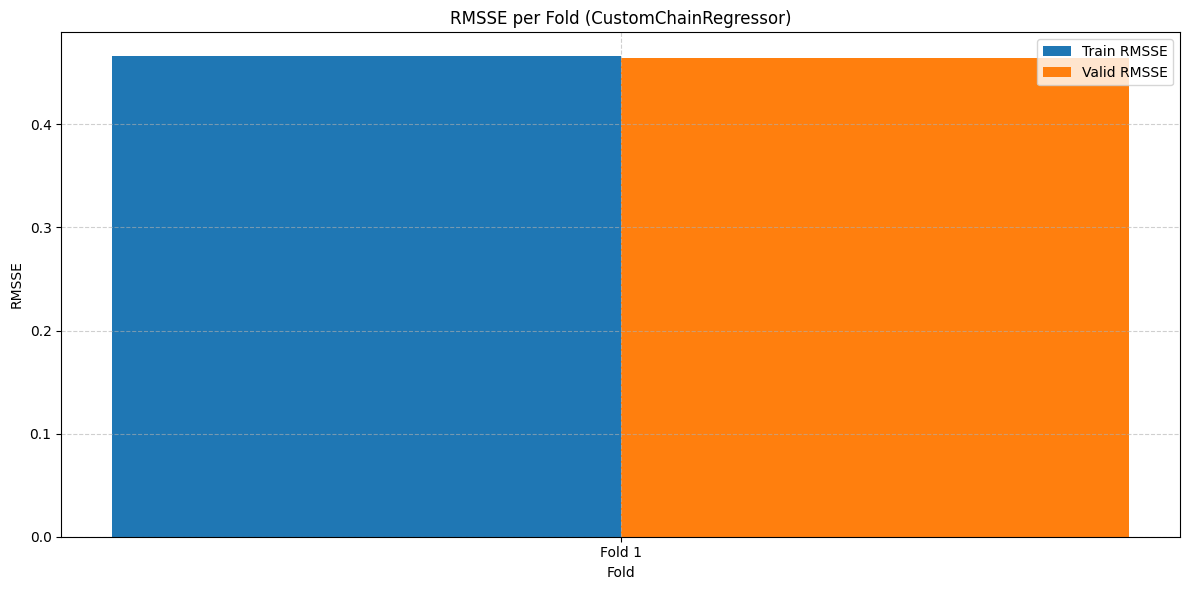

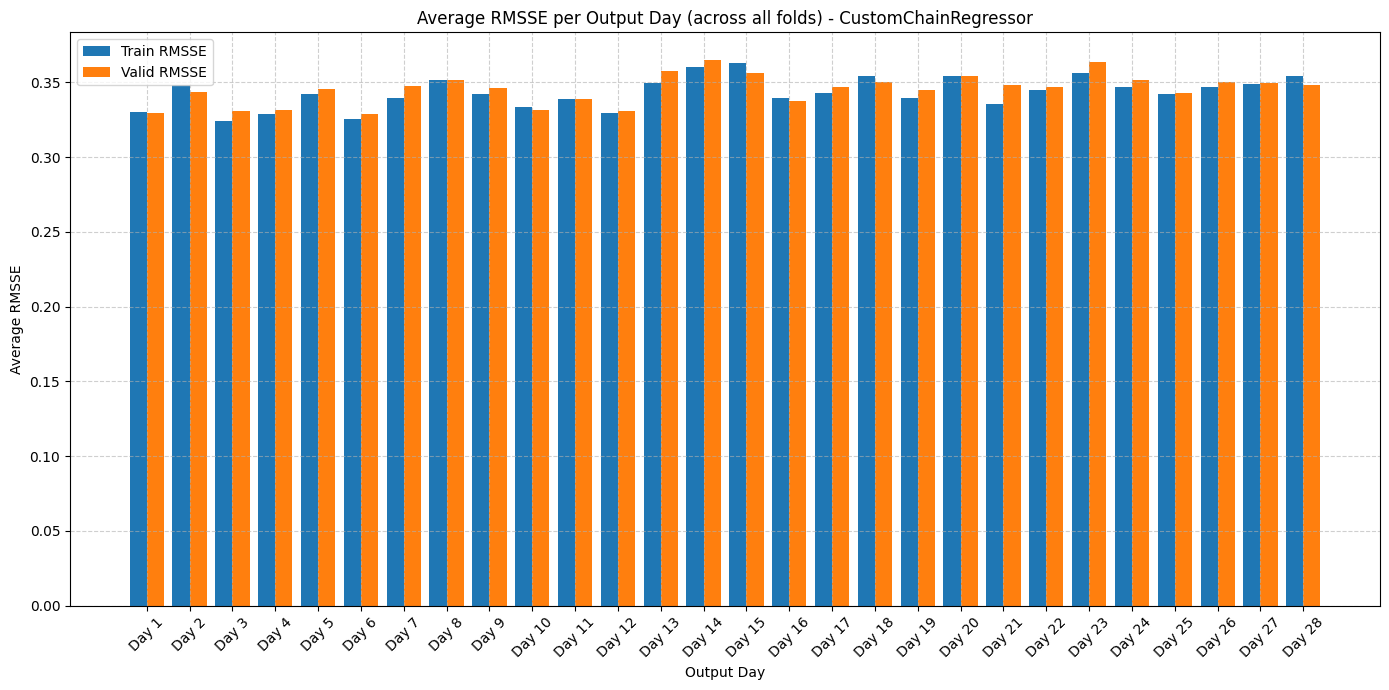


Time Series Forecasting Pipeline with CustomChainRegressor Complete
Total time: 1687.01 seconds
Final average RMSSE across all folds: 0.464681


In [89]:
models, metrics = run_time_series_forecasting_chain(
    X=X,
    y=y,
    index_col='index_day_num',
    n_folds=1,
    test_size=28,
    lagged_features=lagged_features,
    order=list(range(28)),
    categorical_features=categorical_features,
    lgbm_params=TRAINING_PARAMS,
    verbose=1
)

# Save Models

In [75]:
def save_models(models,  # Can be List[MultiOutputRegressor] or single MultiOutputRegressor
               metrics: Dict,
               save_dir: str,
               model_name: str = None,
               feature_names: List[str] = None,
               output_names: List[str] = None,
               metadata: Dict = None,
               compress: bool = True,
               save_format: str = 'joblib',
               is_single_model: bool = None,
               verbose: bool = True) -> str:
    """
    Save trained time series forecasting models and associated metadata

    Args:
        models: List of trained MultiOutputRegressor models OR single MultiOutputRegressor (for final model)
        metrics: Dictionary of evaluation metrics
        save_dir: Directory to save models
        model_name: Base name for saved models (default: timestamp)
        feature_names: List of feature names used for training
        output_names: List of output names (e.g., 'day_1', 'day_2', etc.)
        metadata: Additional metadata to save
        compress: Whether to compress saved files
        save_format: Format to save models ('joblib', 'pickle', or 'lgbm')
        is_single_model: Explicitly specify if models is a single model (auto-detected if None)
        verbose: Whether to print information about saved files

    Returns:
        Path to the saved model directory
    """
    # Auto-detect if it's a single model
    if is_single_model is None:
        is_single_model = not isinstance(models, list)

    # Convert single model to list for consistent processing
    if is_single_model:
        models_list = [models]
        model_type_suffix = "_final"
    else:
        models_list = models
        model_type_suffix = "_cv"

    # Create timestamp for model name if not provided
    if model_name is None:
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        model_name = f"ts_forecast{model_type_suffix}_{timestamp}"

    # Create save directory
    model_dir = os.path.join(save_dir, model_name)
    os.makedirs(model_dir, exist_ok=True)

    if verbose:
        print(f"\n{'='*70}")
        print(f"Saving {'final model' if is_single_model else 'cross-validation models'} to {model_dir}")
        print(f"{'='*70}")

    # Prepare metadata
    if metadata is None:
        metadata = {}

    metadata["save_date"] = datetime.datetime.now().isoformat()
    metadata["n_models"] = len(models_list)
    metadata["model_type"] = "MultiOutputRegressor_LGBM"
    metadata["is_single_model"] = is_single_model

    if feature_names:
        metadata["feature_names"] = feature_names

    if output_names:
        metadata["output_names"] = output_names
    else:
        metadata["output_names"] = [f"day_{i+1}" for i in range(models_list[0].n_outputs_)]

    # Add performance metrics to metadata
    metadata["metrics"] = {}
    for key, value in metrics.items():
        # Convert numpy arrays to lists for JSON serialization
        if isinstance(value, np.ndarray):
            metadata["metrics"][key] = value.tolist()
        # Skip large prediction arrays
        elif key not in ["predictions", "ensemble_prediction"]:
            metadata["metrics"][key] = value

    # Save metadata
    with open(os.path.join(model_dir, "metadata.json"), "w") as f:
        json.dump(metadata, f, indent=2)

    if verbose:
        print(f"Saved metadata to {os.path.join(model_dir, 'metadata.json')}")

    # Save models based on selected format
    if save_format == 'joblib':
        if is_single_model:
            # Save single model
            model_path = os.path.join(model_dir, "final_model.joblib")
            joblib.dump(models_list[0], model_path, compress=compress)

            if verbose:
                print(f"Saved final model to {model_path}")
        else:
            # Save each CV model with joblib
            for i, model in enumerate(models_list):
                model_path = os.path.join(model_dir, f"model_fold_{i+1}.joblib")
                joblib.dump(model, model_path, compress=compress)

                if verbose:
                    print(f"Saved fold {i+1} model to {model_path}")

            # Save all models in a single file
            all_models_path = os.path.join(model_dir, "all_models.joblib")
            joblib.dump(models_list, all_models_path, compress=compress)

            if verbose:
                print(f"Saved all models to {all_models_path}")

    elif save_format == 'pickle':
        if is_single_model:
            # Save single model
            model_path = os.path.join(model_dir, "final_model.pkl")
            with open(model_path, "wb") as f:
                pickle.dump(models_list[0], f)

            if verbose:
                print(f"Saved final model to {model_path}")
        else:
            # Save each CV model with pickle
            for i, model in enumerate(models_list):
                model_path = os.path.join(model_dir, f"model_fold_{i+1}.pkl")
                with open(model_path, "wb") as f:
                    pickle.dump(model, f)

                if verbose:
                    print(f"Saved fold {i+1} model to {model_path}")

            # Save all models in a single file
            all_models_path = os.path.join(model_dir, "all_models.pkl")
            with open(all_models_path, "wb") as f:
                pickle.dump(models_list, f)

            if verbose:
                print(f"Saved all models to {all_models_path}")

    elif save_format == 'lgbm':
        if is_single_model:
            # Save single model using LightGBM's native format
            model_subdir = os.path.join(model_dir, "final_model")
            os.makedirs(model_subdir, exist_ok=True)

            # Save each estimator (one per output/day)
            for j, estimator in enumerate(models_list[0].estimators_):
                estimator_path = os.path.join(model_subdir, f"day_{j+1}.txt")
                estimator.booster_.save_model(estimator_path)

            if verbose:
                print(f"Saved final model to {model_subdir} directory")
        else:
            # Save each CV model using LightGBM's native format
            for i, model in enumerate(models_list):
                model_subdir = os.path.join(model_dir, f"model_fold_{i+1}")
                os.makedirs(model_subdir, exist_ok=True)

                # Save each estimator (one per output/day)
                for j, estimator in enumerate(model.estimators_):
                    estimator_path = os.path.join(model_subdir, f"day_{j+1}.txt")
                    estimator.booster_.save_model(estimator_path)

                if verbose:
                    print(f"Saved fold {i+1} model to {model_subdir} directory")

        # Create a simplified model index file
        model_index = {
            "model_format": "lgbm_native",
            "n_models": len(models_list),
            "n_outputs": models_list[0].n_outputs_,
            "is_single_model": is_single_model,
            "model_paths": ["final_model"] if is_single_model else [f"model_fold_{i+1}" for i in range(len(models_list))]
        }

        with open(os.path.join(model_dir, "model_index.json"), "w") as f:
            json.dump(model_index, f, indent=2)

        if verbose:
            print(f"Saved model index to {os.path.join(model_dir, 'model_index.json')}")

    else:
        raise ValueError(f"Unsupported save format: {save_format}. Use 'joblib', 'pickle', or 'lgbm'.")

    return model_dir

# def load_models(model_dir: str,
#                load_format: str = 'auto',
#                verbose: bool = True) -> Dict[str, Any]:
#     """
#     Load saved time series forecasting models and associated metadata

#     Args:
#         model_dir: Directory containing saved models
#         load_format: Format to load models ('auto', 'joblib', 'pickle', or 'lgbm')
#         verbose: Whether to print information about loaded files

#     Returns:
#         Dictionary containing loaded models and metadata
#     """
#     if verbose:
#         print(f"\n{'='*70}")
#         print(f"Loading models from {model_dir}")
#         print(f"{'='*70}")

#     # Check if directory exists
#     if not os.path.exists(model_dir):
#         raise FileNotFoundError(f"Model directory {model_dir} not found")

#     # Load metadata
#     metadata_path = os.path.join(model_dir, "metadata.json")
#     if os.path.exists(metadata_path):
#         with open(metadata_path, "r") as f:
#             metadata = json.load(f)

#         if verbose:
#             print(f"Loaded metadata from {metadata_path}")
#     else:
#         metadata = {}
#         print(f"Warning: No metadata file found at {metadata_path}")

#     # Determine format to load if auto
#     if load_format == 'auto':
#         if os.path.exists(os.path.join(model_dir, "all_models.joblib")):
#             load_format = 'joblib'
#         elif os.path.exists(os.path.join(model_dir, "all_models.pkl")):
#             load_format = 'pickle'
#         elif os.path.exists(os.path.join(model_dir, "model_index.json")):
#             load_format = 'lgbm'
#         else:
#             # Try to detect based on files present
#             if any(f.endswith('.joblib') for f in os.listdir(model_dir)):
#                 load_format = 'joblib'
#             elif any(f.endswith('.pkl') for f in os.listdir(model_dir)):
#                 load_format = 'pickle'
#             else:
#                 raise ValueError(f"Cannot automatically determine model format in {model_dir}")

#     # Load models based on format
#     if load_format == 'joblib':
#         # Try to load all models from a single file first
#         all_models_path = os.path.join(model_dir, "all_models.joblib")
#         if os.path.exists(all_models_path):
#             models = joblib.load(all_models_path)

#             if verbose:
#                 print(f"Loaded all models from {all_models_path}")
#         else:
#             # Load individual models
#             models = []
#             i = 1
#             while True:
#                 model_path = os.path.join(model_dir, f"model_{i}.joblib")
#                 if not os.path.exists(model_path):
#                     break

#                 models.append(joblib.load(model_path))

#                 if verbose:
#                     print(f"Loaded model {i} from {model_path}")

#                 i += 1

#     elif load_format == 'pickle':
#         # Try to load all models from a single file first
#         all_models_path = os.path.join(model_dir, "all_models.pkl")
#         if os.path.exists(all_models_path):
#             with open(all_models_path, "rb") as f:
#                 models = pickle.load(f)

#             if verbose:
#                 print(f"Loaded all models from {all_models_path}")
#         else:
#             # Load individual models
#             models = []
#             i = 1
#             while True:
#                 model_path = os.path.join(model_dir, f"model_{i}.pkl")
#                 if not os.path.exists(model_path):
#                     break

#                 with open(model_path, "rb") as f:
#                     models.append(pickle.load(f))

#                 if verbose:
#                     print(f"Loaded model {i} from {model_path}")

#                 i += 1

#     elif load_format == 'lgbm':
#         # Load model index
#         index_path = os.path.join(model_dir, "model_index.json")
#         if not os.path.exists(index_path):
#             raise FileNotFoundError(f"Model index file not found at {index_path}")

#         with open(index_path, "r") as f:
#             model_index = json.load(f)

#         if verbose:
#             print(f"Loaded model index from {index_path}")

#         # Import LightGBM for native loading
#         import lightgbm as lgb
#         from sklearn.multioutput import MultiOutputRegressor

#         # Load models
#         models = []
#         n_models = model_index["n_models"]
#         n_outputs = model_index["n_outputs"]

#         for i in range(n_models):
#             model_subdir = os.path.join(model_dir, f"model_{i+1}")

#             # Create a MultiOutputRegressor
#             multi_model = MultiOutputRegressor(lgb.LGBMRegressor())

#             # Load each estimator
#             estimators = []
#             for j in range(n_outputs):
#                 estimator_path = os.path.join(model_subdir, f"day_{j+1}.txt")

#                 # Create a new regressor and load the model
#                 estimator = lgb.LGBMRegressor()
#                 estimator.booster_ = lgb.Booster(model_file=estimator_path)

#                 estimators.append(estimator)

#             # Set the estimators to the MultiOutputRegressor
#             multi_model.estimators_ = estimators

#             models.append(multi_model)

#             if verbose:
#                 print(f"Loaded model {i+1} from {model_subdir}")

#     else:
#         raise ValueError(f"Unsupported load format: {load_format}. Use 'auto', 'joblib', 'pickle', or 'lgbm'.")

#     # Return both models and metadata
#     result = {
#         "models": models,
#         "metadata": metadata
#     }

#     return result

# def make_predictions(models: List[MultiOutputRegressor],
#                     X: pd.DataFrame,
#                     index_col: str = None,
#                     use_ensemble: bool = True,
#                     model_idx: int = None,
#                     output_names: List[str] = None,
#                     verbose: bool = True) -> Dict[str, np.ndarray]:
#     """
#     Make predictions using saved models

#     Args:
#         models: List of trained MultiOutputRegressor models
#         X: Features DataFrame for prediction
#         index_col: Column name for the time index (to be removed from features)
#         use_ensemble: Whether to use ensemble predictions (average of all models)
#         model_idx: Index of specific model to use (overrides use_ensemble)
#         output_names: List of output names for the predictions
#         verbose: Whether to print information during prediction

#     Returns:
#         Dictionary with predictions (individual models and ensemble)
#     """
#     if verbose:
#         print(f"\n{'='*70}")
#         print(f"Making predictions on data with shape {X.shape}")
#         print(f"{'='*70}")

#     # Create a copy of X to avoid modifying the original
#     X_copy = X.copy()

#     # Remove the index column from features if present
#     if index_col and index_col in X_copy.columns:
#         if verbose:
#             print(f"Removing index column '{index_col}' from features")
#         X_copy = X_copy.drop(columns=[index_col])

#     # Prepare output
#     predictions = {}
#     all_model_preds = []

#     # Determine which model(s) to use
#     if model_idx is not None:
#         if model_idx < 0 or model_idx >= len(models):
#             raise ValueError(f"Invalid model_idx: {model_idx}. Must be between 0 and {len(models)-1}")

#         model_indices = [model_idx]
#         if verbose:
#             print(f"Using single model (index {model_idx})")
#     else:
#         model_indices = range(len(models))
#         if verbose:
#             print(f"Using {len(models)} models" +
#                  (" with ensemble averaging" if use_ensemble and len(models) > 1 else ""))

#     # Make predictions with selected models
#     for i in model_indices:
#         model = models[i]

#         # Make prediction
#         start_time = time.time()
#         y_pred = model.predict(X_copy)
#         pred_time = time.time() - start_time

#         # Store prediction
#         predictions[f"model_{i+1}"] = y_pred
#         all_model_preds.append(y_pred)

#         if verbose:
#             print(f"Made predictions with model {i+1} in {pred_time:.3f} seconds")

#     # Create ensemble prediction if requested and multiple models used
#     if use_ensemble and len(all_model_preds) > 1:
#         ensemble_pred = np.mean(all_model_preds, axis=0)
#         predictions["ensemble"] = ensemble_pred

#         if verbose:
#             print(f"Created ensemble prediction from {len(all_model_preds)} models")

#     # Determine final prediction to return
#     if model_idx is not None:
#         final_pred = predictions[f"model_{model_idx+1}"]
#         final_key = f"model_{model_idx+1}"
#     elif use_ensemble and len(all_model_preds) > 1:
#         final_pred = predictions["ensemble"]
#         final_key = "ensemble"
#     else:
#         final_pred = predictions[f"model_{model_indices[0]+1}"]
#         final_key = f"model_{model_indices[0]+1}"

#     # Convert to DataFrame with proper column names if provided
#     if output_names and len(output_names) == final_pred.shape[1]:
#         final_df = pd.DataFrame(final_pred, columns=output_names)
#         predictions["final_df"] = final_df

#         if verbose:
#             print(f"Final prediction using {final_key} with shape {final_pred.shape}")
#     else:
#         # Create default output names
#         default_names = [f"day_{i+1}" for i in range(final_pred.shape[1])]
#         final_df = pd.DataFrame(final_pred, columns=default_names)
#         predictions["final_df"] = final_df

#         if verbose:
#             print(f"Final prediction using {final_key} with shape {final_pred.shape}")

#     # Add the "final" key for convenience
#     predictions["final"] = final_pred

#     return predictions

In [90]:
save_dir = "/content/drive/My Drive/time_series/competition_data/wip"
feature_names = X.columns.tolist()
if "index_day_num" in feature_names:
    feature_names.remove("index_day_num")
output_names = [f"day_{i+1}" for i in range(28)]  # For 28 days prediction

model_dir = save_models(
    models=models,
    metrics=metrics,
    save_dir=save_dir,
    model_name="time_series_chain_cs_full",
    feature_names=feature_names,
    output_names=output_names,
    metadata={"data_source": "my_dataset", "description": "28-day forecast model"},
    save_format="pickle",  # Options: 'joblib', 'pickle', 'lgbm'
    verbose=True
)


Saving cross-validation models to /content/drive/My Drive/time_series/competition_data/wip/time_series_chain_cs_full
Saved metadata to /content/drive/My Drive/time_series/competition_data/wip/time_series_chain_cs_full/metadata.json
Saved fold 1 model to /content/drive/My Drive/time_series/competition_data/wip/time_series_chain_cs_full/model_fold_1.pkl
Saved all models to /content/drive/My Drive/time_series/competition_data/wip/time_series_chain_cs_full/all_models.pkl


# Train final model

In [77]:
FINAL_TRAINING_PARAMS = {
            'objective': 'tweedie',
            'tweedie_variance_power': 1.5,
            'n_estimators': 100,
            'learning_rate': 0.05,
            'max_depth': 6,
            'num_leaves': 31,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42,
            'verbose': -1
        }

In [79]:
def train_final_model_chain(X: pd.DataFrame,
                           y: pd.DataFrame,
                           order: List[int] = None,
                           categorical_features: List[str] = None,
                           params: Dict = None,
                           eval_every: int = 10,
                           verbose: int = 1) -> CustomChainRegressor:
    """
    Train final model on all available data using CustomChainRegressor

    Args:
        X: Features DataFrame
        y: Target values DataFrame with 28 columns
        order: Order for chaining the regressors (default: sequential 0 to n_targets-1)
        categorical_features: List of categorical feature names
        params: LightGBM parameters dictionary
        eval_every: Evaluate and store metrics every n iterations
        verbose: Verbosity level

    Returns:
        Trained CustomChainRegressor model
    """
    if params is None:
        params = {}

    # Set default order if not provided (sequential order)
    if order is None:
        order = list(range(y.shape[1]))

    # Validate order
    if verbose >= 1:
        print(f"Final model validation:")
        print(f"  y shape: {y.shape}")
        print(f"  order: {order}")
        print(f"  order length: {len(order)}")

    # Ensure all order indices are valid
    if order:
        max_order_idx = max(order)
        if max_order_idx >= y.shape[1]:
            raise ValueError(f"Order contains index {max_order_idx} but y only has {y.shape[1]} columns. "
                           f"Maximum valid index is {y.shape[1]-1}")

    # Handle categorical features
    if categorical_features:
        for col in categorical_features:
            if col in X.columns and str(X[col].dtype) != 'category':
                if verbose >= 1:
                    print(f"Converting {col} from {X[col].dtype} to category")
                X[col] = X[col].astype('category')

    if verbose >= 1:
        print(f"\nTraining final CustomChainRegressor on all {len(X)} samples")
        print(f"Target shape: {y.shape} ({y.shape[1]} days/outputs)")
        print(f"Features: {X.shape[1]} columns")
        print(f"Chain order: {order}")
        if categorical_features:
            print(f"Categorical features: {len(categorical_features)} columns")

    # Create base estimator
    base_estimator = LGBMRegressor(**params)

    # Create CustomChainRegressor with the specified order
    final_model = CustomChainRegressor(
        base_estimator=base_estimator,
        order=order,
        random_state=42
    )

    # Fit params to pass to LightGBM
    fit_params = {}
    if categorical_features:
        fit_params['categorical_feature'] = categorical_features

    # Train the model
    start_time = time.time()
    if verbose >= 1:
        print(f"\nStarting chain training...")

    final_model.fit(X, y, **fit_params)

    training_time = time.time() - start_time

    if verbose >= 1:
        print(f"\nTraining complete! Total time: {training_time:.2f} seconds")

        # Make predictions to check performance on training data
        y_pred = final_model.predict(X)

        # Calculate overall metrics
        total_rmse = np.sqrt(mean_squared_error(y.values, y_pred))
        print(f"Overall Train RMSE: {total_rmse:.6f}")

        # Show per-output metrics for last 5 outputs
        print("\nPer-output Train RMSE (last 5 outputs):")
        for i in range(max(0, y.shape[1]-5), y.shape[1]):
            rmse = np.sqrt(mean_squared_error(y.iloc[:, i], y_pred[:, i]))
            print(f"  Output {i+1} (Day {i+1}): {rmse:.6f}")

        # Show metrics for each model in the chain
        print(f"\nChain composition:")
        for i, output_idx in enumerate(final_model.order_):
            print(f"  Model {i+1} in chain predicts output {output_idx+1} (Day {output_idx+1})")

    return final_model



In [91]:
# Direct usage of the new function
final_model = train_final_model_chain(
    X=X,
    y=y,
    order=list(range(28)),
    categorical_features=categorical_features,
    params=TRAINING_PARAMS,
    verbose=1
)

Final model validation:
  y shape: (2707512, 28)
  order: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
  order length: 28

Training final CustomChainRegressor on all 2707512 samples
Target shape: (2707512, 28) (28 days/outputs)
Features: 55 columns
Chain order: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
Categorical features: 10 columns

Starting chain training...

Training complete! Total time: 1447.96 seconds
Overall Train RMSE: 2.038766

Per-output Train RMSE (last 5 outputs):
  Output 24 (Day 24): 2.078662
  Output 25 (Day 25): 2.080370
  Output 26 (Day 26): 2.063420
  Output 27 (Day 27): 2.095935
  Output 28 (Day 28): 2.104216

Chain composition:
  Model 1 in chain predicts output 1 (Day 1)
  Model 2 in chain predicts output 2 (Day 2)
  Model 3 in chain predicts output 3 (Day 3)
  Model 4 in chain predicts output 4 (Day 4)
  Model 5 in chain predicts output 5 (Day 5

Add:
1. Training a model on all of the data.
2. Process one of the validation set and perdict the model. examine predictions vs. labels

In [92]:
model_dir = save_models(
    models=final_model,
    metrics=metrics,
    save_dir=save_dir,
    model_name="time_series_chain_full_final",
    feature_names=feature_names,
    output_names=output_names,
    metadata={"data_source": "my_dataset", "description": "28-day forecast model"},
    save_format="pickle",  # Options: 'joblib', 'pickle', 'lgbm'
    is_single_model=True,
    verbose=True
)


Saving final model to /content/drive/My Drive/time_series/competition_data/wip/time_series_chain_full_final
Saved metadata to /content/drive/My Drive/time_series/competition_data/wip/time_series_chain_full_final/metadata.json
Saved final model to /content/drive/My Drive/time_series/competition_data/wip/time_series_chain_full_final/final_model.pkl


In [93]:
X.shape

(2707512, 55)